# Basic EDA

Number of samples in training data: 220025
                                         id  label  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   
2  755db6279dae599ebb4d39a9123cce439965282d      0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   
4  068aba587a4950175d04c680d38943fd488d6a9d      0   

                                          image_path  
0  /kaggle/input/histopathologic-cancer-detection...  
1  /kaggle/input/histopathologic-cancer-detection...  
2  /kaggle/input/histopathologic-cancer-detection...  
3  /kaggle/input/histopathologic-cancer-detection...  
4  /kaggle/input/histopathologic-cancer-detection...  

Class distribution:
label
0    130908
1     89117
Name: count, dtype: int64


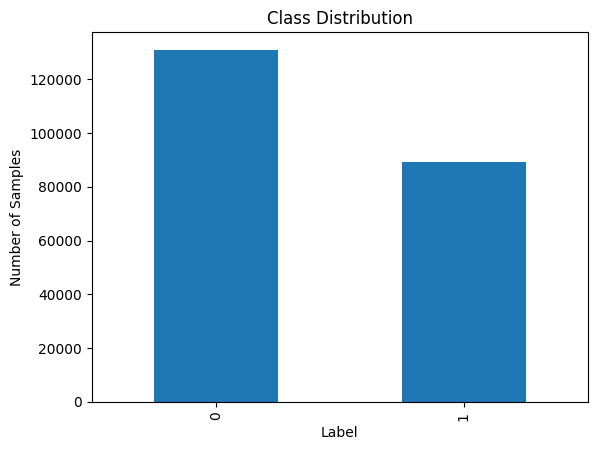

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os

data_path = '/kaggle/input/histopathologic-cancer-detection'

train_dir = os.path.join(data_path, 'train')
train_labels_df = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

train_labels_df['image_path'] = train_labels_df['id'].apply(lambda x: os.path.join(train_dir, x + '.tif'))

print(f'Number of samples in training data: {len(train_labels_df)}')

print(train_labels_df.head())

print("\nClass distribution:")
print(train_labels_df['label'].value_counts())

# Class distribution visualization
train_labels_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.show()

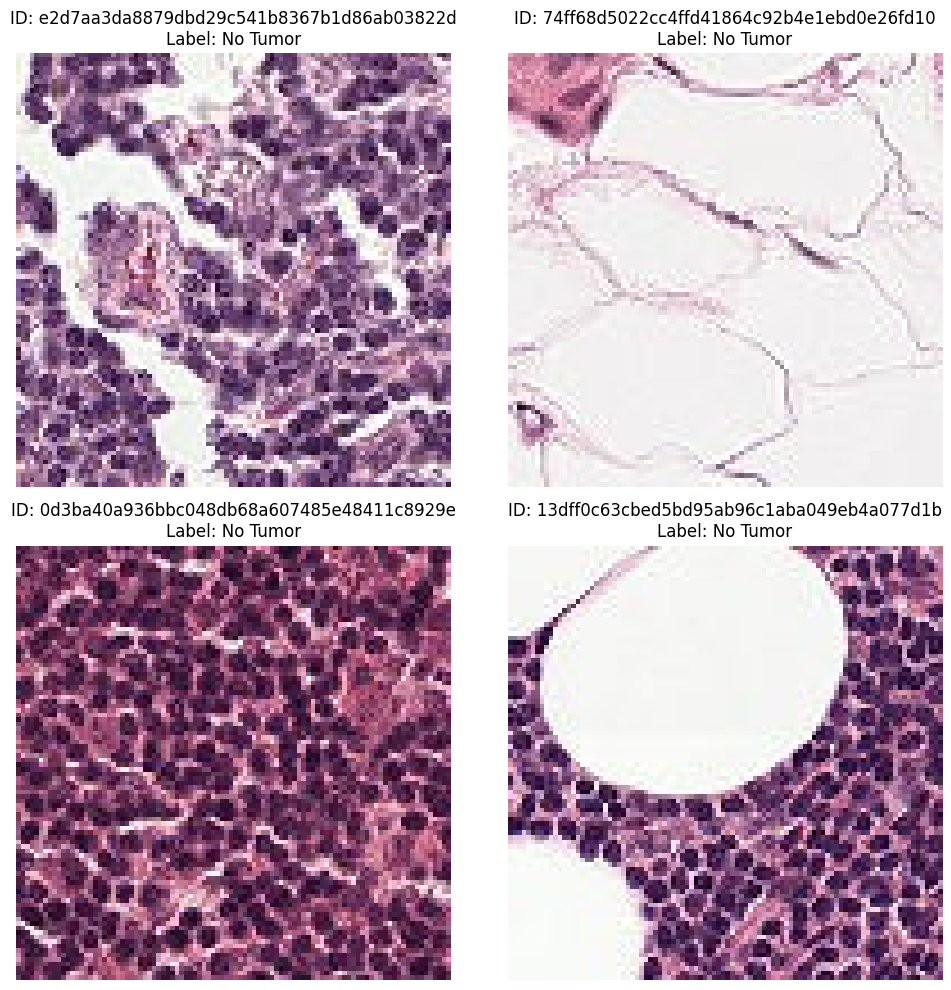

In [19]:
import random
from PIL import Image

train_images_dir = os.path.join(data_path, 'train')

random_image_ids = random.sample(train_labels_df['id'].tolist(), 4)

plt.figure(figsize=(10, 10))

for i, image_id in enumerate(random_image_ids):
    image_path = os.path.join(train_images_dir, f'{image_id}.tif')

    try:
        img = Image.open(image_path)

        label = train_labels_df[train_labels_df['id'] == image_id]['label'].iloc[0]
        label_text = 'Tumor' if label == 1 else 'No Tumor'

        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title(f'ID: {image_id}\nLabel: {label_text}')
        plt.axis('off')

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred while processing image {image_id}: {e}")

plt.tight_layout()
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df, val_df = train_test_split(train_labels_df, test_size=0.2, random_state=42, stratify=train_labels_df['label'])

# Check the size of the training and validation sets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Check the label distribution in the training and validation sets (optional, but good practice)
print("\nTraining set label distribution:")
print(train_df['label'].value_counts(normalize=True))
print("\nValidation set label distribution:")
print(val_df['label'].value_counts(normalize=True))


Training set size: 176020
Validation set size: 44005

Training set label distribution:
label
0    0.594966
1    0.405034
Name: proportion, dtype: float64

Validation set label distribution:
label
0    0.594978
1    0.405022
Name: proportion, dtype: float64


In [21]:
import tensorflow as tf

# --- Configuration ---
IMG_SIZE = 96 # The images are 96x96 pixels
BATCH_SIZE = 64 # Process images in batches of 64
AUTOTUNE = tf.data.AUTOTUNE # Let tf.data optimize performance automatically

# --- Function to Load and Preprocess an Image ---
def load_and_preprocess_image(image_path, label):
    # 1. Read the file
    img = tf.io.read_file(image_path)
    # 2. Decode the TIFF image (3 color channels: Red, Green, Blue)
    img = tf.io.decode_tiff(img)[0] # decode_tiff returns a list, take the first element
    # 3. Resize (if needed, though these are already 96x96)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    # 4. Normalize pixel values to be between 0 and 1 (good for neural networks)
    img = img / 255.0
    return img, label

# --- Function for Data Augmentation ---
def augment_image(image, label):
    # Apply random transformations ONLY during training
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(image)
    # You could add rotations, brightness changes, etc. here
    # img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return img, label

# --- Create tf.data.Dataset objects ---
# 1. Create datasets from our pandas DataFrames
train_ds = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['label'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['label'].values))

# --- Build the Training Pipeline ---
print("Building Training Pipeline...")
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_df)) # Shuffle the training data
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE) # Load and preprocess images in parallel
    .map(augment_image, num_parallel_calls=AUTOTUNE) # Apply augmentations
    .batch(BATCH_SIZE) # Group images into batches
    .prefetch(buffer_size=AUTOTUNE) # Prepare next batches while the GPU is busy
)
print("Training Pipeline Built.")

# --- Build the Validation Pipeline ---
print("Building Validation Pipeline...")
val_ds = (
    val_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE) # Load and preprocess
    # NO shuffling or augmentation for validation! We want consistent evaluation.
    .batch(BATCH_SIZE) # Group into batches
    .prefetch(buffer_size=AUTOTUNE) # Prepare next batches
)
print("Validation Pipeline Built.")

# --- Check a batch ---
print("\nChecking one batch from the training dataset:")
for images, labels in train_ds.take(1): # Take just one batch
    print("Images batch shape:", images.shape) # Should be (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)
    print("Labels batch shape:", labels.shape) # Should be (BATCH_SIZE,)
    print("Labels in batch:", labels.numpy())

Building Training Pipeline...


2025-04-18 20:27:33.284607: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


AttributeError: in user code:

    File "/tmp/ipykernel_111/3770503693.py", line 13, in load_and_preprocess_image  *
        img = tf.io.decode_tiff(img)[0] # decode_tiff returns a list, take the first element

    AttributeError: module 'tensorflow._api.v2.io' has no attribute 'decode_tiff'
